In [44]:
import pandas as pd
import json
import xml.etree.ElementTree as ET
import os
import seaborn as sns
import numpy as np
import re

gold_files = {
    "ptpt": '../sources/assin-ptpt-test.xml',
    "ptbr": '../sources/assin-ptbr-test.xml',
    "assin2": '../sources/assin2-test.xml'
}

def xml_reader(xml_file, score):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    entry_list = []
    for pair in root.iter('pair'):
        yield {
            "t": pair.find('t').text,
            "h": pair.find('h').text,
            "score": pair.get(score)
            }

def generate_report(root, name, score):
    path = os.path.join(root, name)
    test_scores = [x for x in xml_reader(path, score)]

    for item in gold_files.items():
        if item[0] in path:
            gold_file = item[1]
    
    gold_scores = [x for x in xml_reader(gold_file, score)]
    
    test_df = pd.DataFrame(test_scores)
    gold_df = pd.DataFrame(gold_scores)
    
    gold_df = gold_df.rename(columns={'score' : 'gold_score'})
    
    df = gold_df.merge(test_df, how='outer', on=['t', 'h'])
    
    if score == 'similarity':
        df['score'] = df['score'].astype(float)
        df['gold_score'] = df['gold_score'].astype(float)
        df['error'] = df['score'] - df['gold_score']
    if score == 'entailment':
        df['error'] = df['score'].combine(df['gold_score'], lambda x,y: x != y)
    df = df.sort_values('error', ascending=False)
    
    df = df[['t', 'h', 'score', 'gold_score', 'error']]
    
    return df

def get_reports(report_folder, score):
    for root, dirs, files in os.walk(report_folder):
        for name in files:
            if name.endswith('.xml'):
                yield {
                    "name": name,
                    "root": root,
                    "df": generate_report(root, name, score)
                }
                
def process_reports(report_folder, score):            
    for idx, item in enumerate(get_reports(report_folder, score)):
        technique = {
        'ensemble' : 'Ensemble (stacking)',
        'average' : 'Ensemble (averaging)',
        'english' : 'RoBERTa',
        'portuguese': 'BERT'
        }
    
        df = item['df']
        df['TEST_ID'] = idx
        df['dataset'] = item['root'].split('/')[-2]
        models = re.split('[0-9]+folds', item['root'].split('/')[-1])[0].split('_')
    
        for entry in technique.items():
            if entry[0] in item['name']:
                df['technique'] = entry[1]
    
        if 'ensemble' in item['name']:
            folds = int(re.findall('[0-9]+', re.findall('[0-9]+folds',item['root'])[0])[0])
            df['folds'] = folds
        else:
            df['folds'] = None

        if 'english' or 'ensemble' or 'average' in item['name']:
            df['english model'] = models[0]
        else:
            df['english model'] = None

        if not 'english' in item['name']:
            df['portuguese model'] = models[1]
        else:
            df['portuguese model'] = None
            
        if score == 'similarity':
            df['task'] = 'STS'
        elif score == 'entailment':
            df['task'] = 'RTE'
            
        yield df[['TEST_ID', 'dataset', 'task', 'technique', \
                  'english model', 'portuguese model', 'folds', 't', 'h', 'score', 'gold_score', 'error']]

dataframes = []
for measure in ['similarity', 'entailment']:
    for item in process_reports('../reports', measure):
        dataframes.append(item)

df = pd.concat(dataframes)

df.to_csv('../reports/full_report.csv')

Text(0.5, 1.0, 'Gold scores distribution - ASSIN 1 ( pt-BR )')

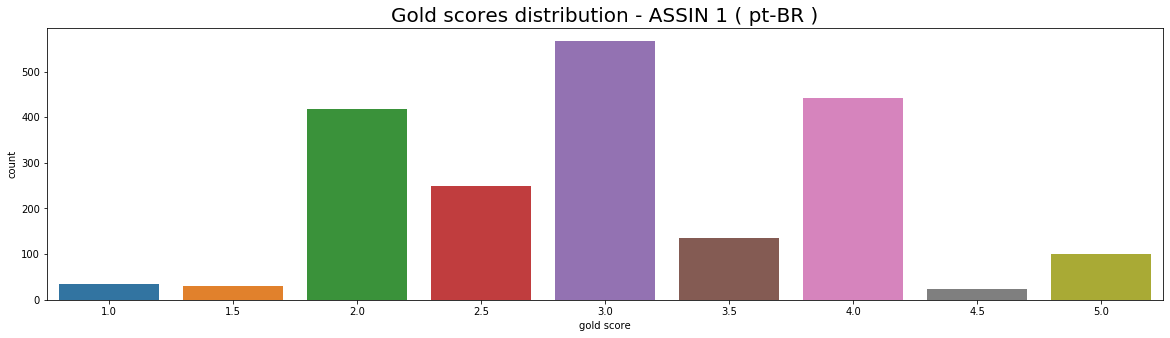

In [47]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)

df = pd.read_csv('../reports/full_report.csv')

query = {
    "dataset" : "assin-ptbr",
    "task": "STS",
    "technique": "Ensemble (stacking)",
    "english model": "roberta-large",
    "portuguese model": "portuguese-bert",
    "folds": 20
}

for item in query.items():
    df = df[df[item[0]]==item[1]]
    
df = df[['score', 'gold_score']]
df['gold_score'] = df['gold_score'].apply(lambda x: np.round(x * 2 ) / 2 )

plot = df.groupby('gold_score').count().reset_index().rename(columns={'gold_score': 'gold score', 'score': 'count'})

g = sns.barplot(x='gold score', y='count', data=plot)

g.set_title('Gold scores distribution - ASSIN 1 ( pt-BR )', fontsize=20)

In [48]:
df = pd.read_csv('../reports/full_report.csv')

query = {
    "dataset" : "assin-ptbr",
    "task": "STS",
    "technique": "Ensemble (stacking)",
    "english model": "roberta-large",
    "portuguese model": "portuguese-bert",
    "folds": 20
}

for item in query.items():
    df = df[df[item[0]]==item[1]]

pd.set_option('display.max_colwidth', -1)
df = df[['t', 'h', 'score', 'gold_score', 'error']]
for item in ['score', 'gold_score', 'error']:
    df[item] = df[item].apply(lambda x: np.round(x,2))
print(df.head(20).to_latex())

\begin{tabular}{lllrrr}
\toprule
{} &                                                                                                                 t &                                                                                                                  h &  score &  gold\_score &  error \\
\midrule
102000 &  A partir de terça, haverá atendimento normalmente até sábado, das 7 às 18 horas. &  No sábado, as obras paralisam das 0h às 14h. &  2.45 &  1.00 &  1.45 \\
102001 &  Quanto pior, pior para o conjunto da população brasileira. &  Enfrentamos um momento que muita gente considera que quanto pior, melhor. &  2.69 &  1.25 &  1.44 \\
102002 &  Você está acostumado com outra parte da tabela e se vê envolvido em outros colocações. &  Você ganha dois títulos, esta acostumado a ficar em outra parte da tabela, e tem uma trava. &  3.28 &  2.00 &  1.28 \\
102003 &  A Venezuela já havia faturado a prata em 1992 e o bronze em 2005. &  A Venezuela só participou das Olimpíadas em Barce

In [49]:
print(df.tail(20).to_latex())

\begin{tabular}{lllrrr}
\toprule
{} &                                                                                                                           t &                                                                                                       h &  score &  gold\_score &  error \\
\midrule
103980 &  O 24º reforço do Palmeiras em 2015 assinou contrato com o clube nesta segunda-feira. &  Lucas Barrios assinou contrato com o clubealviverde na noite desta segunda-feira (13). &  2.72 &  3.75 & -1.03 \\
103981 &  Disponível nas versões preta e branca, ele deverá custar R\$ 2.199. &  O produto estará disponível nas redes de varejo nas versões preta ou branca. &  2.95 &  4.00 & -1.05 \\
103982 &  Com o aumento, o preço do botijão deve passar para cerca de R\$ 50,00. &  A alta para o consumidor será de cerca de R\$ 3 por botijão. &  2.69 &  3.75 & -1.06 \\
103983 &  Esses tipos de meteoros são bastante comuns na chuva Perseidas. &  Agosto terá chuva de meteoros Perseidas a